# **Links from where to get the directories**

In [ ]:
%pip install gdown
import gdown
#ethnicity
url_eth = "https://drive.google.com/drive/folders/1ZKMUq6U6pRw7zcP6AkGxoQVX3LnMnGXC?usp=share_link"
#gender
url_gen="https://drive.google.com/drive/folders/1hKgsi0EAsyDAKlVV6WEnK8LvslfLc9ME?usp=drive_link"
#age
url_age="https://drive.google.com/drive/folders/1B77SD7Eh9mbaoGIa7Dcaleqaee-wlMMm?usp=drive_link"
gdown.download_folder(url_eth, quiet=True)
gdown.download_folder(url_gen, quiet=True)
gdown.download_folder(url_age, quiet=True)

['/content/splitted_by_age/eyes.zip',
 '/content/splitted_by_age/mouth.zip',
 '/content/splitted_by_age/nose.zip']

# **IMPORT THE NECESSARY LIBRARIES FOR THE NOTEBOOK TO WORK**

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import zipfile
import shutil
from collections import defaultdict
from PIL import Image
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from torch.utils.data import  Dataset
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Extracting the directories from the zip files**

In [ ]:
# Datapath Project_Biometric/Dataset
#ethinicity
folder_path_eth = "splitted_dataset"
#gender
folder_path_gen = "splitted_by_gender"
#age
folder_path_age="splitted_by_age"
folders=[folder_path_eth,folder_path_gen,folder_path_age]
for folder_path in folders:
  for file_name in os.listdir(folder_path):

      # zipped files in the folder biometric_systems_dataset
      if file_name.endswith(".zip"):

        # full path to the zip file
        file_path = os.path.join(folder_path, file_name)

        # create folder in the same path with the name of the zip file
        extract_folder = os.path.join(folder_path, file_name.replace(".zip", ""))
        os.makedirs(extract_folder, exist_ok=True)

        # open and extract the file
        with zipfile.ZipFile(file_path, mode="r") as zip_ref:
          zip_ref.extractall(extract_folder)
        os.remove(file_path)

  for folder in os.listdir(folder_path):
      dir_path = os.path.join(folder_path, folder)

      if os.path.isdir(folder_path):
          train_folder = os.path.join(dir_path, "train")
          test_folder = os.path.join(dir_path, "test")

          train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
          test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

          print(f"Cartella '{folder}':")
          print(f"  Train set: {train_count} file")
          print(f"  Test set: {test_count} file")

Cartella 'dlib_face_recognition_resnet_model_v1.dat':
  Train set: 0 file
  Test set: 0 file
Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'nose':
  Train set: 18424 file
  Test set: 4607 file
Cartella 'eyes':
  Train set: 18424 file
  Test set: 4607 file
Cartella 'mouth':
  Train set: 18424 file
  Test set: 4607 file
Cartella 'nose':
  Train set: 18421 file
  Test set: 4610 file
Cartella 'eyes':
  Train set: 18421 file
  Test set: 4610 file
Cartella 'mouth':
  Train set: 18421 file
  Test set: 4610 file


# **COMPUTING THE HISTOGRAMS FOR THE LBP**

In [ ]:
def calculate_lbp(image, R=2, P=7):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply LBP operator
    lbp = local_binary_pattern(gray, P=8, R=3, method='uniform')
    #lbp = cv2.LBP(gray, neighbors, radius)

    # Calculate histogram
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= hist.sum() + 1e-7
    return hist

# **CREATING THE DATASETS**

**Ethnicity**

In [ ]:
# Dataset personalizzato
class EthnicityDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []
        self.features=[]


        # Scansione della cartella per ottenere i file
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Considerando immagini .jpg e .png
                self.images.append(filename)
                parts = filename.split('_')
                if len(parts) >= 4:
                    #ethnicity
                    label = parts[3]  # The ethnicity is the fourth element (indice 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Ethnicity map
                    self.labels.append(label_map.get(label, -1))
        self.labels=np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        label = self.labels[idx]
        # self.labels.append(label)
        # Calculate LBP features
        image = np.array(image)  # Convert to NumPy array for OpenCV
        feature = calculate_lbp(image)
        self.features.append(feature)  # Store features (optional)
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return feature, label

**Gender**

In [ ]:
class GenderDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []
        self.features=[]


        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                self.images.append(filename)
                parts = filename.split('_')
                if len(parts) >= 4:
                    #gender
                    label=parts[2]
                    label_map={"0":0,"1":1}
                    self.labels.append(label_map.get(label, -1))
        self.labels=np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        label = self.labels[idx]
        # self.labels.append(label)
        # Calculate LBP features
        image = np.array(image)  # Convert to NumPy array for OpenCV
        feature = calculate_lbp(image)
        self.features.append(feature)  # Store features (optional)
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return feature, label

**Age**

In [ ]:
class AgeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []
        self.features=[]


        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                self.images.append(filename)
                parts = filename.split('_')
                if len(parts) >= 4:
                    #age
                    label=parts[1]
                    label=int(label)
                    label_map = {}
                    for i in range(1, 117):
                        if 1 <= i <= 5:
                            label_map[i] = 0
                        elif 6 <= i <= 12:
                            label_map[i] = 1
                        elif 13 <= i <= 20:
                            label_map[i] = 2
                        elif 21 <= i <= 35:
                            label_map[i] = 3
                        elif 36 <= i <= 50:
                            label_map[i] = 4
                        elif 51 <= i <= 75:
                            label_map[i] = 5
                        elif 76 <= i <= 90:
                            label_map[i] = 6
                        elif 91 <= i <= 116:
                             label_map[i] = 7
                    self.labels.append(label_map.get(label, -1))
        self.labels=np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        label = self.labels[idx]
        # self.labels.append(label)
        # Calculate LBP features
        image = np.array(image)  # Convert to NumPy array for OpenCV
        feature = calculate_lbp(image)
        self.features.append(feature)  # Store features (optional)
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return feature, label

# **EXTRACTING THE FEATURES FROM THE DATASET**

In [ ]:
def extract_lbp_features(dataset):
    """
    Args:
        images: A list of images, where each image is a NumPy array.

    Returns:
        A NumPy array of LBP features.
    """
    features = []

    for _ in range(len(dataset)):
      image, label = dataset[_]
    return np.array(dataset.features)

# **Function to compute the weights**

In [ ]:
def compute_class_weight(classes, y, majority_class_weight_factor):
    # """Computes class weights based on class frequency.

    # Args:
    #     class_weight: The class weighting strategy (e.g., 'balanced').
    #     classes: A list of class labels.
    #     y: The true labels of the training data.

    # Returns:
    #     A dictionary mapping class labels to their corresponding weights.
    # """
# Calculate class frequencies
        class_counts = np.bincount(y)
        # Calculate class weights inversely proportional to frequency
        class_weights = 1. / class_counts
        # Normalize weights
        #class_weights = class_weights / (class_weights.sum() * len(classes))
        majority_class_index = np.argmax(class_counts)
        class_weights = class_weights / np.mean(class_weights)
        class_weights[majority_class_index] *= majority_class_weight_factor
        class_weights = dict(enumerate(class_weights))
        return class_weights

# **EYES TRAINING VALIDATION AND TEST**

**Ethnicity Datasets**

In [ ]:
#Initialize the dataset

#ethnicity
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/eyes/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/eyes/test")

X_train = extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

**Gender Datasets**

In [ ]:
#Initialize the dataset
#gender
full_train_dataset = GenderDataset(root_dir="/content/splitted_by_gender/eyes/train")
test_dataset = GenderDataset(root_dir="/content/splitted_by_gender/eyes/test")

# Extract features for all images in one line
X_train = extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

**Age Dataset**

In [ ]:
#Initialize the dataset
#age
full_train_dataset = AgeDataset(root_dir="/content/splitted_by_age/eyes/train")
test_dataset = AgeDataset(root_dir="/content/splitted_by_age/eyes/test")

# Extract features for all images in one line
X_train = extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels  # Now contains numerical labels

X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

# **Using SMOTE to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train,y_train=X_resampled,y_resampled

# **Using RandomOverSampler and RandomUnderSampler to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)  # Apply over-sampling
X_train, y_train = rus.fit_resample(X_ros, y_ros)  # Apply under-sampling

In [ ]:
# print(X_train.shape)
# print(y_train[0])
# Extract the first column (labels)
labels = y_train[:]

# Count the occurrences of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the frequencies
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 5000 occurrences
Label 1: 3529 occurrences
Label 2: 3500 occurrences
Label 3: 3500 occurrences
Label 4: 3000 occurrences


# **Computing the weights and producing the datasets for the models**

---



In [ ]:
#majority_class_weight_factor=2.5 when using Ethnicity
#majority_class_weight_factor=1.5 when using Gender
#majority_class_weight_factor=1.5 when using Age

class_weights = compute_class_weight(classes=np.unique(y_train), y=y_train, majority_class_weight_factor=2.5)
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])
train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")

# **Using GridSearchCV to tune the hyperparameters(Already done)**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}


In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}

# **Training the model on the newly found hyperparameters and predicting the labels**

In [ ]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=100
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.36589
[20]	valid_0's multi_logloss: 1.31976
[30]	valid_0's multi_logloss: 1.29739
[40]	valid_0's multi_logloss: 1.285
[50]	valid_0's multi_logloss: 1.27798
[60]	valid_0's multi_logloss: 1.27385
[70]	valid_0's multi_logloss: 1.27161
[80]	valid_0's multi_logloss: 1.26954
[90]	valid_0's multi_logloss: 1.26854
[100]	valid_0's multi_logloss: 1.26781
[110]	valid_0's multi_logloss: 1.26708
[120]	valid_0's multi_logloss: 1.26676
[130]	valid_0's multi_logloss: 1.26669
[140]	valid_0's multi_logloss: 1.26653
[150]	valid_0's multi_logloss: 1.26626
[160]	valid_0's multi_logloss: 1.26641
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 1.2662


**Ethnicity predictions and classification report**

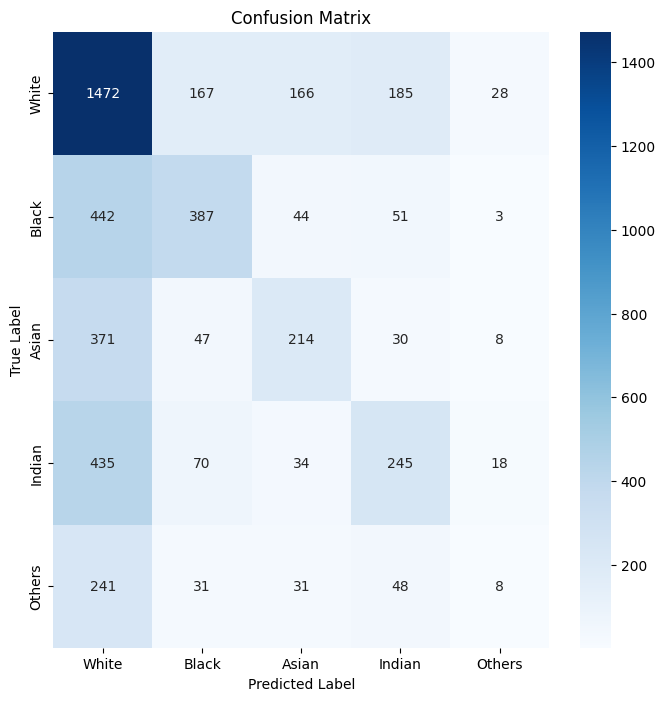

              precision    recall  f1-score   support

       White       0.50      0.73      0.59      2018
       Black       0.55      0.42      0.48       927
       Asian       0.44      0.32      0.37       670
      Indian       0.44      0.31      0.36       802
      Others       0.12      0.02      0.04       359

    accuracy                           0.49      4776
   macro avg       0.41      0.36      0.37      4776
weighted avg       0.46      0.49      0.46      4776



In [ ]:
class_names = ["White", "Black", "Asian", "Indian", "Others"]
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Gender**

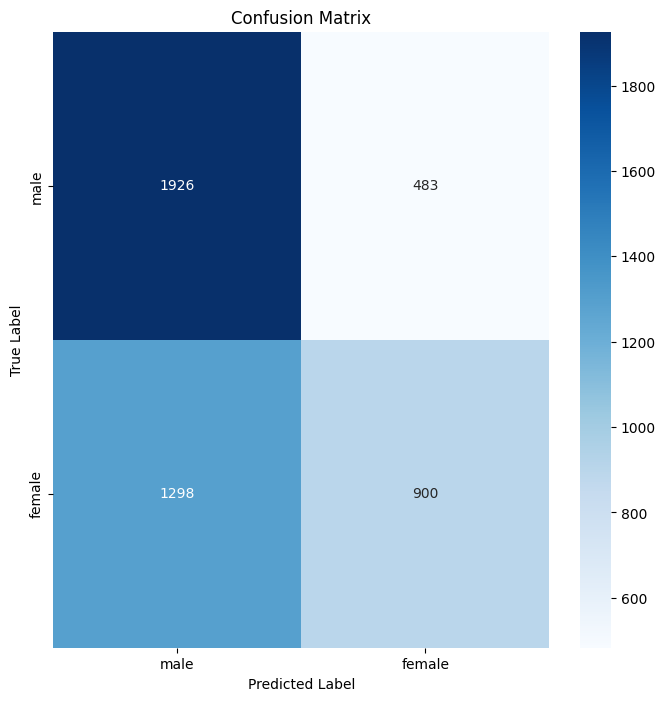

              precision    recall  f1-score   support

        male       0.60      0.80      0.68      2409
      female       0.65      0.41      0.50      2198

    accuracy                           0.61      4607
   macro avg       0.62      0.60      0.59      4607
weighted avg       0.62      0.61      0.60      4607



In [ ]:
class_names=['male','female']
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Age**

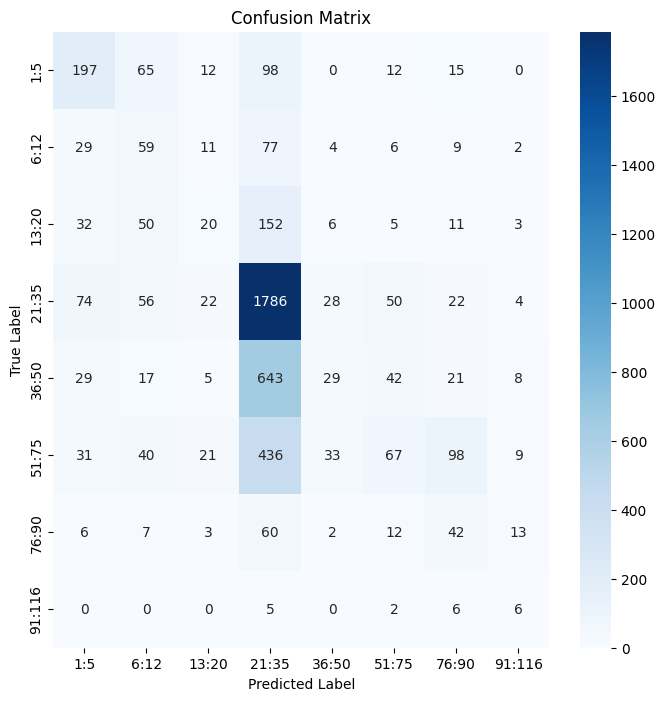

              precision    recall  f1-score   support

         1:5       0.49      0.49      0.49       399
        6:12       0.20      0.30      0.24       197
       13:20       0.21      0.07      0.11       279
       21:35       0.55      0.87      0.67      2042
       36:50       0.28      0.04      0.06       794
       51:75       0.34      0.09      0.14       735
       76:90       0.19      0.29      0.23       145
      91:116       0.13      0.32      0.19        19

    accuracy                           0.48      4610
   macro avg       0.30      0.31      0.27      4610
weighted avg       0.42      0.48      0.40      4610



In [ ]:
class_names=["1:5", "6:12","13:20", "21:35", "36:50", "51:75", "76:90", "91:116",]
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

# **Training the grid_search model and predicting the labels(Not mandatory to run)**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.49      0.77      0.60      2018
           1       0.53      0.46      0.49       927
           2       0.50      0.24      0.33       670
           3       0.45      0.28      0.34       802
           4       0.33      0.01      0.01       359

    accuracy                           0.50      4776
   macro avg       0.46      0.35      0.35      4776
weighted avg       0.48      0.50      0.45      4776



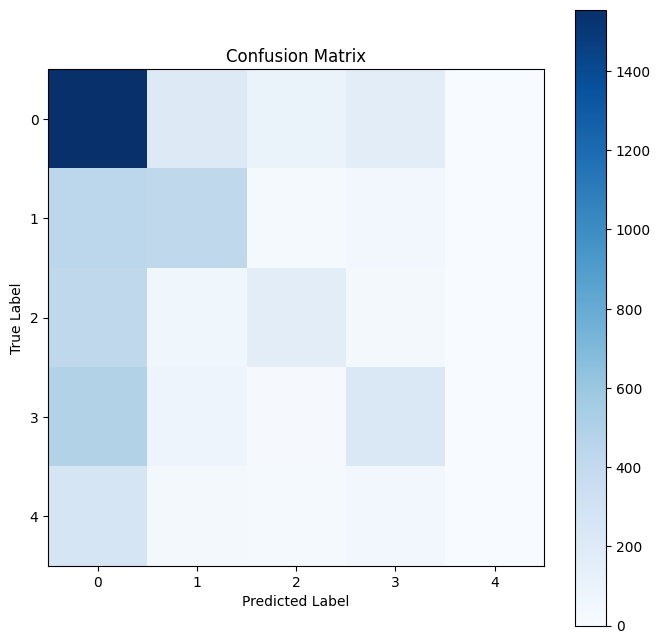

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# Define a mapping of numbers to labels
labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

# Create a new array with corresponding labels
y_test_labels = np.vectorize(labels.get)(y_test)
y_pred_classes_labels= np.vectorize(labels.get)(y_pred)

#print(y_test_labels)
#print(y_pred_classes_labels)
print(classification_report(y_test_labels,y_pred_classes_labels))

              precision    recall  f1-score   support

       Asian       0.50      0.24      0.33       670
       Black       0.53      0.46      0.49       927
      Indian       0.45      0.28      0.34       802
      Others       0.33      0.01      0.01       359
       White       0.49      0.77      0.60      2018

    accuracy                           0.50      4776
   macro avg       0.46      0.35      0.35      4776
weighted avg       0.48      0.50      0.45      4776



In [ ]:
# Get a list of image filenames
#ethnicity
image_filenames = os.listdir("/content/splitted_dataset/eyes/test")
#gender
#image_filenames = os.listdir("/content/splitted_by_gender/eyes/test")
#age
# image_filenames = os.listdir("/content/splitted_by_age/eyes/test")

# Create a DataFrame with image names and predicted labels
df = pd.DataFrame({'Image_Name': image_filenames, 'Predicted_Label': y_pred_classes})

# Save the DataFrame ethnicity to a CSV file
# df.to_csv("predictions_ethnicity_eyes.csv", index=False)
# Save the DataFrame gender to a CSV file
df.to_csv("predictions_gender_eyes.csv", index=False)
# Save the DataFrame age to a CSV file
# df.to_csv("predictions_age_eyes.csv", index=False)

# **MOUTH TRAINING AND TEST VALIDATION**

**Ethnicity**

In [ ]:
#Initiliaze the dataset
#ethnicity
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/mouth/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/mouth/test")

X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

y_test=test_dataset.labels
X_test = extract_lbp_features(test_dataset)

**Gender**

In [ ]:
#Initiliaze the dataset
#gender
full_train_dataset = GenderDataset(root_dir="/content/splitted_by_gender/mouth/train")
test_dataset = GenderDataset(root_dir="/content/splitted_by_gender/mouth/test")

# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

y_test=test_dataset.labels
X_test = extract_lbp_features(test_dataset)

**Age**

In [ ]:
#Initiliaze the dataset
#age
full_train_dataset = AgeDataset(root_dir="/content/splitted_by_age/mouth/train")
test_dataset = AgeDataset(root_dir="/content/splitted_by_age/mouth/test")

# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

y_test=test_dataset.labels
X_test = extract_lbp_features(test_dataset)

# **Sampling procedure on the dataset**

In [ ]:
# ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
# rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Apply oversampling
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# **Changing the weights on the training set and producing the datasets for the models**

---



In [ ]:
#majority_class_weight_factor=2.5 when using Ethnicity
#majority_class_weight_factor=1.5 when using Gender
#majority_class_weight_factor=3.25 when using Age

class_weights = compute_class_weight(classes=np.unique(y_train), y=y_train, majority_class_weight_factor=3.25)
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])
train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")

# **Using GridSearchCV to tune the hyperparameters(Already done)**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_resampled)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}


In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}


# **Using SMOTE to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train,y_train=X_resampled,y_resampled

# **Using RandomOverSampler and RandomUnderSampler to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)  # Apply over-sampling
X_train, y_train = rus.fit_resample(X_ros, y_ros)  # Apply under-sampling

In [ ]:
# print(X_train.shape)
# print(y_train[0])
# Extract the first column (labels)
labels = y_train[:]

# Count the occurrences of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the frequencies
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 5000 occurrences
Label 1: 3529 occurrences
Label 2: 3500 occurrences
Label 3: 3500 occurrences
Label 4: 3000 occurrences


# **Training the model on the newly found hyperparameters and predicting the labels**

In [ ]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=100
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.67973
[20]	valid_0's multi_logloss: 1.62257
[30]	valid_0's multi_logloss: 1.58948
[40]	valid_0's multi_logloss: 1.56944
[50]	valid_0's multi_logloss: 1.55588
[60]	valid_0's multi_logloss: 1.54584
[70]	valid_0's multi_logloss: 1.53794
[80]	valid_0's multi_logloss: 1.5322
[90]	valid_0's multi_logloss: 1.52757
[100]	valid_0's multi_logloss: 1.5236
[110]	valid_0's multi_logloss: 1.52054
[120]	valid_0's multi_logloss: 1.51759
[130]	valid_0's multi_logloss: 1.5149
[140]	valid_0's multi_logloss: 1.51229
[150]	valid_0's multi_logloss: 1.50988
[160]	valid_0's multi_logloss: 1.50808
[170]	valid_0's multi_logloss: 1.50732
[180]	valid_0's multi_logloss: 1.50645
[190]	valid_0's multi_logloss: 1.50595
[200]	valid_0's multi_logloss: 1.50565
Did not meet early stopping. Best iteration is:
[196]	valid_0's multi_logloss: 1.50563


**Ethnicity**

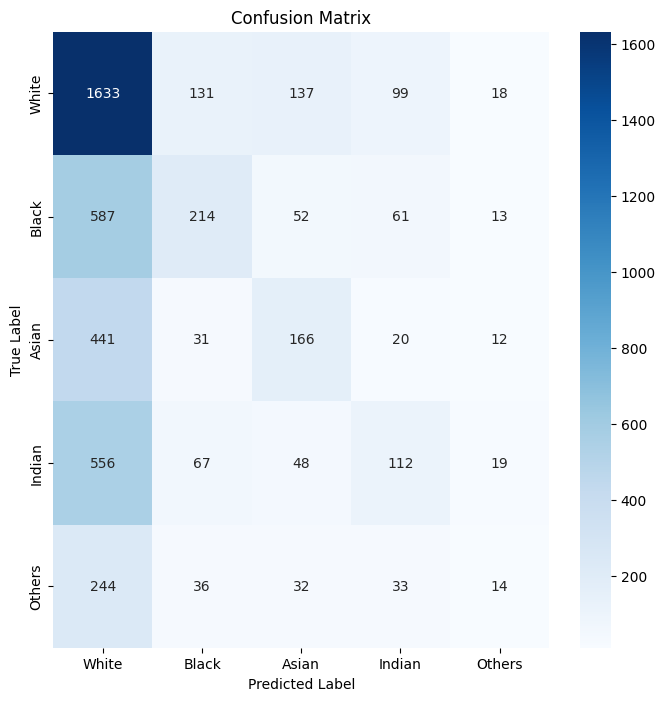

              precision    recall  f1-score   support

       White       0.47      0.81      0.60      2018
       Black       0.45      0.23      0.30       927
       Asian       0.38      0.25      0.30       670
      Indian       0.34      0.14      0.20       802
      Others       0.18      0.04      0.06       359

    accuracy                           0.45      4776
   macro avg       0.37      0.29      0.29      4776
weighted avg       0.41      0.45      0.39      4776



In [ ]:
class_names = ["White", "Black", "Asian", "Indian", "Others"]
# label_map={0:'White',1:'Black',2:'Asian',3:'Indian',4:'Others'}
# y_test_classes=[label_map[i] for i in y_test]
# y_pred_classes_eth=[label_map[i] for i in y_pred_classes]

# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Gender**

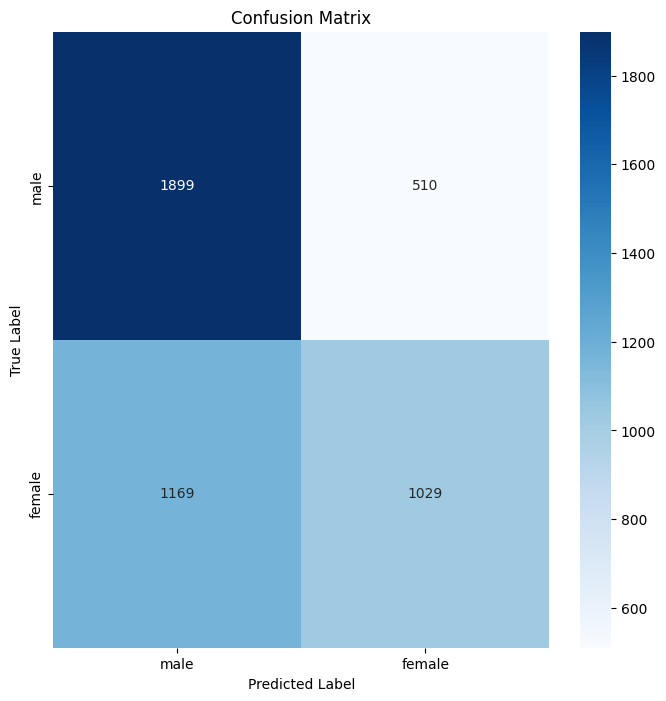

              precision    recall  f1-score   support

        male       0.62      0.79      0.69      2409
      female       0.67      0.47      0.55      2198

    accuracy                           0.64      4607
   macro avg       0.64      0.63      0.62      4607
weighted avg       0.64      0.64      0.63      4607



In [ ]:
class_names=['male','female']
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Age**

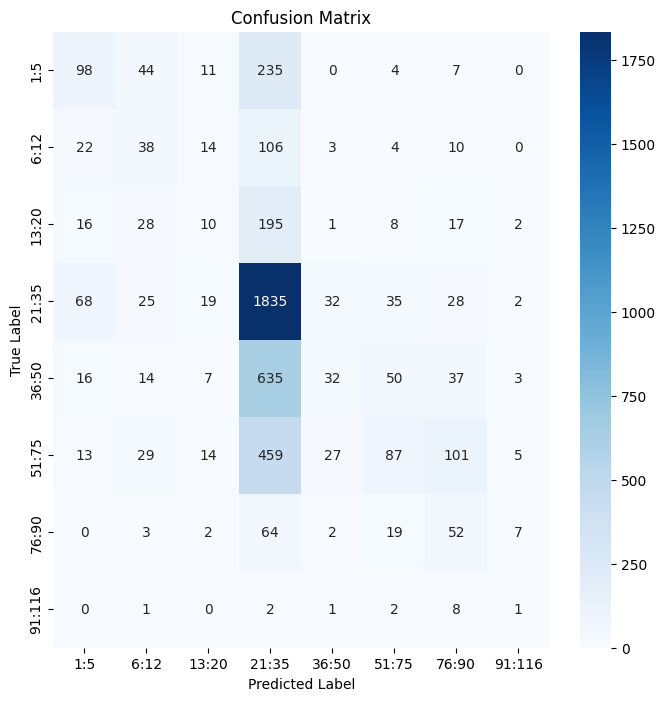

              precision    recall  f1-score   support

         1:5       0.42      0.25      0.31       399
        6:12       0.21      0.19      0.20       197
       13:20       0.13      0.04      0.06       277
       21:35       0.52      0.90      0.66      2044
       36:50       0.33      0.04      0.07       794
       51:75       0.42      0.12      0.18       735
       76:90       0.20      0.35      0.25       149
      91:116       0.05      0.07      0.06        15

    accuracy                           0.47      4610
   macro avg       0.28      0.24      0.22      4610
weighted avg       0.41      0.47      0.38      4610



In [ ]:
class_names=["1:5", "6:12","13:20", "21:35", "36:50", "51:75", "76:90", "91:116",]
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

# **Training the grid_search model and predicting the labels(Not mandatory to run)**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2018
           1       0.42      0.27      0.33       927
           2       0.43      0.12      0.19       670
           3       0.34      0.11      0.16       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.33      0.27      0.26      4776
weighted avg       0.39      0.45      0.37      4776



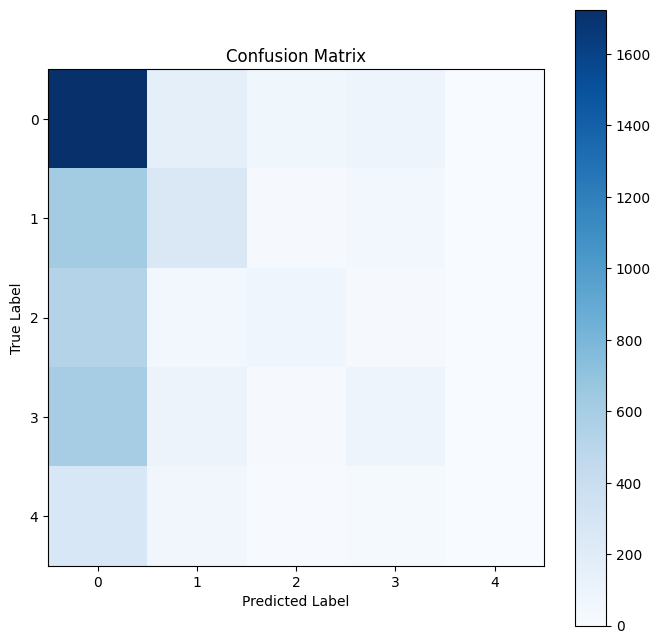

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# Define a mapping of numbers to labels
labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

# Create a new array with corresponding labels
y_test_labels = np.vectorize(labels.get)(y_test)
y_pred_classes_labels= np.vectorize(labels.get)(y_pred)

#print(y_test_labels)
#print(y_pred_classes_labels)
print(classification_report(y_test_labels,y_pred_classes_labels))

              precision    recall  f1-score   support

       Asian       0.43      0.12      0.19       670
       Black       0.42      0.27      0.33       927
      Indian       0.34      0.11      0.16       802
      Others       0.00      0.00      0.00       359
       White       0.46      0.85      0.60      2018

    accuracy                           0.45      4776
   macro avg       0.33      0.27      0.26      4776
weighted avg       0.39      0.45      0.37      4776



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **NOSE TRAINING AND TEST VALIDATION**

**Ethnicity**

In [ ]:
#Initialize the dataset
#Ethnicity
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/nose/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/nose/test")

X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels
X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels


**Gender**

In [ ]:
#Initialize the dataset

#gender
full_train_dataset = GenderDataset(root_dir="/content/splitted_by_gender/nose/train")
test_dataset = GenderDataset(root_dir="/content/splitted_by_gender/nose/test")

X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels
X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels


**Age**

In [ ]:
#Initialize the dataset
#age
full_train_dataset = AgeDataset(root_dir="/content/splitted_by_age/nose/train")
test_dataset = AgeDataset(root_dir="/content/splitted_by_age/nose/test")

X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels
X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

# **Sampling procedure on the dataset**

In [ ]:
# ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
# rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Apply oversampling
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# **Changing the weights on the training set and producing the datasets for the models**

---



In [ ]:
#majority_class_weight_factor=2.5 when using Ethnicity
#majority_class_weight_factor=1.5 when using Gender
#majority_class_weight_factor=4.5 when using Age

class_weights = compute_class_weight(classes=np.unique(y_train), y=y_train, majority_class_weight_factor=2.5)
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])
train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")

# **Using GridSearchCV to tune the hyperparameters(Already done)**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


KeyboardInterrupt: 

# **Using SMOTE to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train,y_train=X_resampled,y_resampled

# **Using RandomOverSampler and RandomUnderSampler to balance out the dataset(Optional)**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)  # Apply over-sampling
X_train, y_train = rus.fit_resample(X_ros, y_ros)  # Apply under-sampling

In [ ]:
# print(X_train.shape)
# print(y_train[0])
# Extract the first column (labels)
labels = y_train[:]

# Count the occurrences of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the frequencies
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 5000 occurrences
Label 1: 3529 occurrences
Label 2: 3500 occurrences
Label 3: 3500 occurrences
Label 4: 3000 occurrences


# **Training the model on the newly found hyperparameters and predicting the labels**

In [ ]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=200
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.41517
[20]	valid_0's multi_logloss: 1.38822
[30]	valid_0's multi_logloss: 1.37735
[40]	valid_0's multi_logloss: 1.37304
[50]	valid_0's multi_logloss: 1.37112
[60]	valid_0's multi_logloss: 1.36977
[70]	valid_0's multi_logloss: 1.36972
[80]	valid_0's multi_logloss: 1.36899
[90]	valid_0's multi_logloss: 1.36892
[100]	valid_0's multi_logloss: 1.36836
[110]	valid_0's multi_logloss: 1.36844
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 1.36833


**Ethnicity**

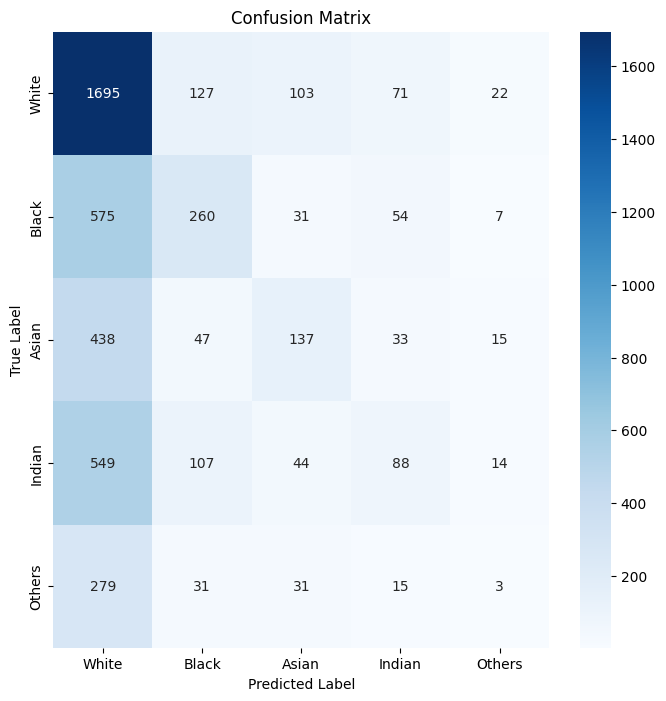

              precision    recall  f1-score   support

       White       0.48      0.84      0.61      2018
       Black       0.45      0.28      0.35       927
       Asian       0.40      0.20      0.27       670
      Indian       0.34      0.11      0.17       802
      Others       0.05      0.01      0.01       359

    accuracy                           0.46      4776
   macro avg       0.34      0.29      0.28      4776
weighted avg       0.41      0.46      0.39      4776



In [ ]:
class_names = ["White", "Black", "Asian", "Indian", "Others"]
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Gender**

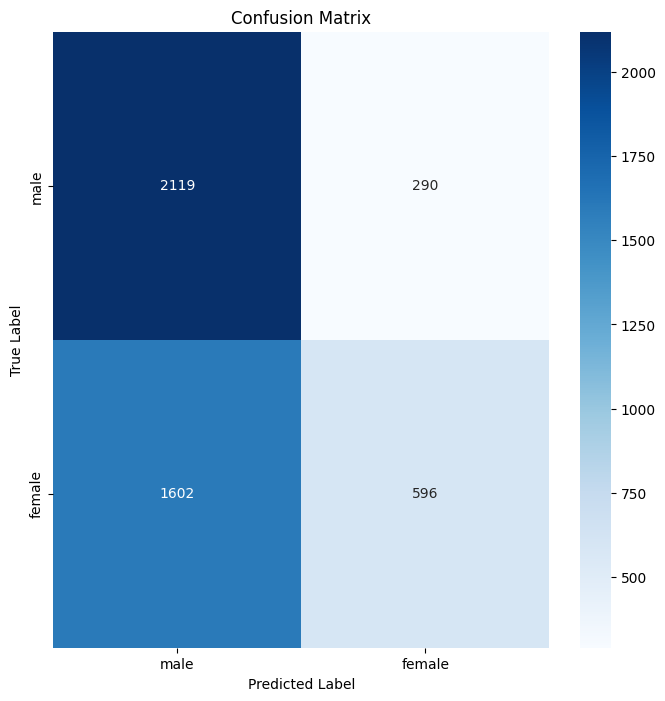

              precision    recall  f1-score   support

        male       0.57      0.88      0.69      2409
      female       0.67      0.27      0.39      2198

    accuracy                           0.59      4607
   macro avg       0.62      0.58      0.54      4607
weighted avg       0.62      0.59      0.55      4607



In [ ]:
class_names=['male','female']
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

**Age**

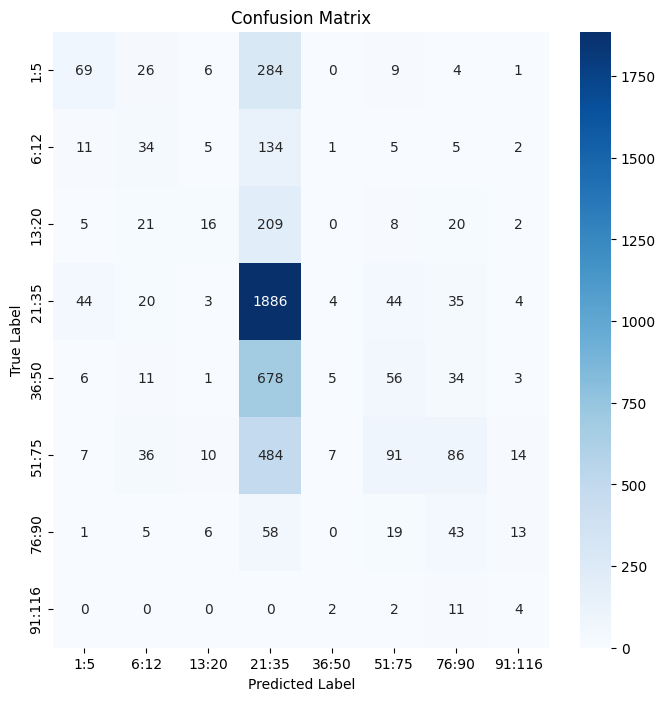

              precision    recall  f1-score   support

         1:5       0.48      0.17      0.25       399
        6:12       0.22      0.17      0.19       197
       13:20       0.34      0.06      0.10       281
       21:35       0.51      0.92      0.65      2040
       36:50       0.26      0.01      0.01       794
       51:75       0.39      0.12      0.19       735
       76:90       0.18      0.30      0.22       145
      91:116       0.09      0.21      0.13        19

    accuracy                           0.47      4610
   macro avg       0.31      0.25      0.22      4610
weighted avg       0.41      0.47      0.37      4610



In [ ]:
class_names=["1:5", "6:12","13:20", "21:35", "36:50", "51:75", "76:90", "91:116",]
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes,target_names=class_names))

# **Training the grid_search model and predicting the labels(Not mandatory to run)**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

              precision    recall  f1-score   support

           0       0.47      0.85      0.61      2018
           1       0.41      0.32      0.36       927
           2       0.47      0.15      0.22       670
           3       0.30      0.07      0.12       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.33      0.28      0.26      4776
weighted avg       0.40      0.45      0.38      4776



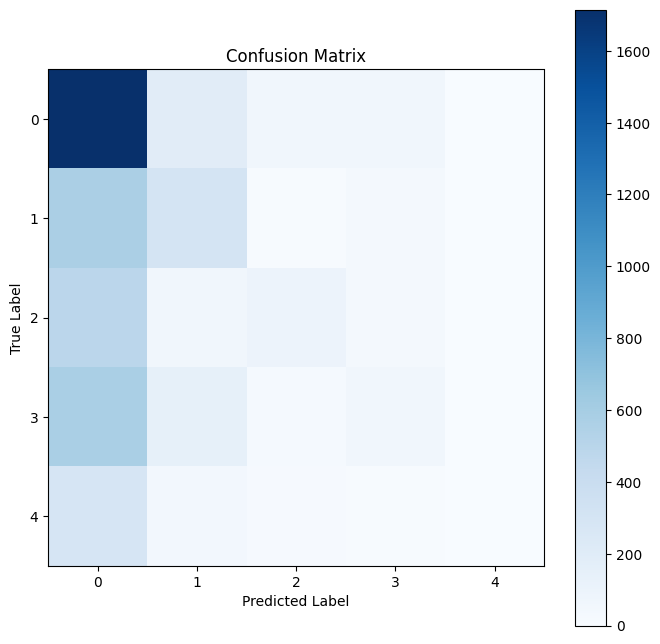

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# Get a list of image filenames
#ethnicity
# image_filenames = os.listdir("/content/splitted_dataset/nose/test")
#gender
image_filenames = os.listdir("/content/splitted_by_gender/nose/test")
#age
# image_filenames = os.listdir("/content/splitted_by_age/nose/test")

# Create a DataFrame with image names and predicted labels
df = pd.DataFrame({'Image_Name': image_filenames, 'Predicted_Label': y_pred_classes})

# Save the DataFrame ethnicity to a CSV file
# df.to_csv("predictions_nose.csv", index=False)
# Save the DataFrame gender to a CSV file
# df.to_csv("predictions_gender_nose.csv", index=False)
# Save the DataFrame age to a CSV file
df.to_csv("predictions_age_nose.csv", index=False)

[5000 3000 3500 3500 3000]
<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 1.1752	valid_1's multi_logloss: 1.40524
[40]	training's multi_logloss: 1.10698	valid_1's multi_logloss: 1.39561
[60]	training's multi_logloss: 1.0638	valid_1's multi_logloss: 1.3964
Early stopping, best iteration is:
[43]	training's multi_logloss: 1.09835	valid_1's multi_logloss: 1.39553
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.44      0.97      0.61      2018
           1       0.54      0.13      0.21       927
           2       0.48      0.06      0.10       670
           3       0.47      0.03      0.05       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.39      0.24      0.19      4776
weighted avg       0.44      0.45      0.32      4776



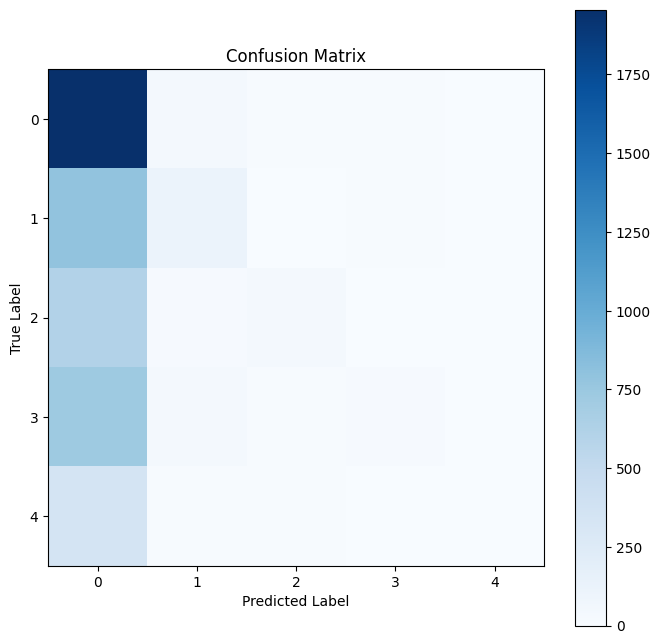

In [ ]:


# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[train_data,test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}

# **KFold**

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    X_train_resampled, X_val_resampled = X_train[train_index], X_train[val_index]
    y_train_resampled, y_val_resampled = y_train[train_index], y_train[val_index]

    class_weights = compute_class_weight(classes=np.unique(y_train_resampled), y=y_train_resampled, majority_class_weight_factor=1.5)
    # Create class weights array for each sample
    class_weights = np.array([class_weights[label] for label in y_train_resampled])

    train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled,weight=class_weights)
    val_data = lgb.Dataset(X_val_resampled, label=y_val_resampled)

    model = lgb.train(bst_prms,
                      train_data,
                      num_round,
                      valid_sets=val_data,
                      callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

    y_pred = model.predict(X_val_resampled, num_iteration=model.best_iteration)
    y_pred_classes = y_pred.argmax(axis=1)

    # Evaluate the model on the validation fold
    print(f"Fold {fold+1} Classification Report:")
    print(classification_report(y_val_resampled, y_pred_classes))
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.46387
[20]	valid_0's multi_logloss: 1.40463
[30]	valid_0's multi_logloss: 1.37067
[40]	valid_0's multi_logloss: 1.3503
[50]	valid_0's multi_logloss: 1.33585
[60]	valid_0's multi_logloss: 1.32733
[70]	valid_0's multi_logloss: 1.32038
[80]	valid_0's multi_logloss: 1.31407
[90]	valid_0's multi_logloss: 1.30856
[100]	valid_0's multi_logloss: 1.3031
[110]	valid_0's multi_logloss: 1.29745
[120]	valid_0's multi_logloss: 1.2927
[130]	valid_0's multi_logloss: 1.28843
[140]	valid_0's multi_logloss: 1.28538
[150]	valid_0's multi_logloss: 1.28135
[160]	valid_0's multi_logloss: 1.2775
[170]	valid_0's multi_logloss: 1.27443
[180]	valid_0's multi_logloss: 1.27232
[190]	valid_0's multi_logloss: 1.2694
[200]	valid_0's multi_logloss: 1.26558
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.26558
Fold 1 Classification Report:
              precision    recall  f1-score   support

 

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's multi_logloss: 1.39258
[30]	valid_0's multi_logloss: 1.35955
[40]	valid_0's multi_logloss: 1.3393
[50]	valid_0's multi_logloss: 1.3252
[60]	valid_0's multi_logloss: 1.31631
[70]	valid_0's multi_logloss: 1.3072
[80]	valid_0's multi_logloss: 1.30076
[90]	valid_0's multi_logloss: 1.29433
[100]	valid_0's multi_logloss: 1.29007
[110]	valid_0's multi_logloss: 1.2851
[120]	valid_0's multi_logloss: 1.28038
[130]	valid_0's multi_logloss: 1.2757
[140]	valid_0's multi_logloss: 1.27221
[150]	valid_0's multi_logloss: 1.2683
[160]	valid_0's multi_logloss: 1.26516
[170]	valid_0's multi_logloss: 1.26245
[180]	valid_0's multi_logloss: 1.25864
[190]	valid_0's multi_logloss: 1.25534
[200]	valid_0's multi_logloss: 1.25229
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.25229
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.47      0.46       992
           1       0.52      0.57      0.54    

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's multi_logloss: 1.40164
[30]	valid_0's multi_logloss: 1.37009
[40]	valid_0's multi_logloss: 1.35108
[50]	valid_0's multi_logloss: 1.33816
[60]	valid_0's multi_logloss: 1.32856
[70]	valid_0's multi_logloss: 1.32259
[80]	valid_0's multi_logloss: 1.31748
[90]	valid_0's multi_logloss: 1.31197
[100]	valid_0's multi_logloss: 1.30745
[110]	valid_0's multi_logloss: 1.30282
[120]	valid_0's multi_logloss: 1.2986
[130]	valid_0's multi_logloss: 1.29406
[140]	valid_0's multi_logloss: 1.28993
[150]	valid_0's multi_logloss: 1.28644
[160]	valid_0's multi_logloss: 1.28348
[170]	valid_0's multi_logloss: 1.28
[180]	valid_0's multi_logloss: 1.27567
[190]	valid_0's multi_logloss: 1.27282
[200]	valid_0's multi_logloss: 1.26954
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.26954
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47      1024
           1       0.50      0.54      0.52  

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's multi_logloss: 1.4057
[30]	valid_0's multi_logloss: 1.3759
[40]	valid_0's multi_logloss: 1.35661
[50]	valid_0's multi_logloss: 1.34342
[60]	valid_0's multi_logloss: 1.33525
[70]	valid_0's multi_logloss: 1.32832
[80]	valid_0's multi_logloss: 1.32339
[90]	valid_0's multi_logloss: 1.31899
[100]	valid_0's multi_logloss: 1.31531
[110]	valid_0's multi_logloss: 1.31139
[120]	valid_0's multi_logloss: 1.30749
[130]	valid_0's multi_logloss: 1.30282
[140]	valid_0's multi_logloss: 1.29848
[150]	valid_0's multi_logloss: 1.29429
[160]	valid_0's multi_logloss: 1.29137
[170]	valid_0's multi_logloss: 1.28818
[180]	valid_0's multi_logloss: 1.2854
[190]	valid_0's multi_logloss: 1.28178
[200]	valid_0's multi_logloss: 1.27833
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.27833
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42      1015
           1       0.51      0.59      0.55 

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[20]	valid_0's multi_logloss: 1.39461
[30]	valid_0's multi_logloss: 1.36018
[40]	valid_0's multi_logloss: 1.33829
[50]	valid_0's multi_logloss: 1.32325
[60]	valid_0's multi_logloss: 1.31186
[70]	valid_0's multi_logloss: 1.30345
[80]	valid_0's multi_logloss: 1.29684
[90]	valid_0's multi_logloss: 1.29095
[100]	valid_0's multi_logloss: 1.28595
[110]	valid_0's multi_logloss: 1.28135
[120]	valid_0's multi_logloss: 1.27703
[130]	valid_0's multi_logloss: 1.2723
[140]	valid_0's multi_logloss: 1.26781
[150]	valid_0's multi_logloss: 1.26382
[160]	valid_0's multi_logloss: 1.25961
[170]	valid_0's multi_logloss: 1.25527
[180]	valid_0's multi_logloss: 1.25042
[190]	valid_0's multi_logloss: 1.24628
[200]	valid_0's multi_logloss: 1.24154
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.24154
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       980
           1       0.53      0.57      0.5